<a href="https://colab.research.google.com/github/Enrique720/Proyecto-BigData/blob/main/Proyecto_Pillow_Angel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocesamiento

In [ ]:
!pip install ray

In [3]:
import os
import shutil
from PIL import Image
from numpy import asarray, remainder
import time
import ray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_workers = 4
ray.init(num_cpus=num_workers, ignore_reinit_error=True)

{'metrics_export_port': 61497,
 'node_id': '3872d4ac3f604b23aef044ad46ddd5751ed82ca3686b1674ef7b8e0e',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-12-08_01-27-32_818031_60/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-12-08_01-27-32_818031_60/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-12-08_01-27-32_818031_60',
 'webui_url': None}

In [5]:
work_dir = '/content/drive/MyDrive/01BigData/BigDataProject'
src_dataset_dir = 'RAW_FISH_DATASET'
aug_dataset_dir = 'AUGMENTED DATASET/PILLOW'
list_species = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel',
                'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

In [6]:
def clean_create_workspace():
    print("*** Clean_Create_Workspace ***")
    print("-- Delete previous directories --")
    for directory in list_species:
        try:
            dir_path = os.path.join(work_dir, aug_dataset_dir, directory)
            shutil.rmtree(dir_path)
            print("Directory successfully deleted:", dir_path)
        except OSError as e:
            print("OS msg:", e.strerror)

    print("-- Create directories --")
    for directory in list_species:
        dir_path = os.path.join(work_dir, aug_dataset_dir, directory)
        os.mkdir(dir_path)
        print("Directory successfully created:", dir_path)

In [7]:
# Helper function: usada para numerar los archivos aumentados
# Input: un numero tipo int
# Return: un numero tipo string
def convert_num_string(num):
    len_final_str = 5
    num_str = str(num)
    remainder = len_final_str - len(num_str)
    ans = remainder * '0' + num_str  # Eg.  ans = '00012'
    return ans

In [8]:
# Funcion que realiza augmentation de data: Resize(590, 445)px, rotation, flip
# Input: recibe la lista de especies 'list_spacies' y un factor 'n'
# Output: realiza un aumento de fotos de tamaño = #fotos_raw_data * n
def augmentation_data(list_species, n):
  print("*** Augmentation_Data ***")
  for specie in list_species:
    print("\nProcessing specie:", specie)
    src_dir = os.path.join(work_dir, src_dataset_dir, specie)
    dest_dataset_dir = os.path.join(work_dir, aug_dataset_dir, specie)
    num_file = 1
    for filename in os.listdir(src_dir):
      # load image
      pic_path = src_dir + "/" + filename
      #print("\nProcessing picture:", pic_path)
      image = Image.open(pic_path)
      # Resize Image
      #print('> Original size: %s %s' % (image.size))
      image.thumbnail((590, 445))
      #print('> Final size: %s %s' % (image.size))
      # Por cada iteracion genera 2 transformaciones del archivo
      num_iter = n + 1 if (n % 2 > 0) else n
      num_iter = int(num_iter / 2)
      for i in range(num_iter):
        # Transformation #1: Flip image
        img_transformed = image.transpose(Image.FLIP_LEFT_RIGHT)
        # Save flipped image
        format_file = filename.split('.')[1]
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        #print("save file: ", dest_path_file)
        img_transformed.save(dest_path_file)
        # Transformation #2: rotation
        img_transformed = img_transformed.rotate(25 * (i + 1))
        # Save rotated image
        num_file += 1
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        img_transformed.save(dest_path_file)
        #print("save file: ", dest_path_file)
        num_file += 1

In [ ]:
# Funcion que realiza augmentation de data: Resize(590, 445)px, rotation, flip
# Input: recibe la lista de especies 'list_spacies' y un factor 'n'
# Output: realiza un aumento de fotos de tamaño = #fotos_raw_data * n
@ray.remote
def augmentation_data_ray(list_species, n):
  print("*** Augmentation_Data ***")
  for specie in list_species:
    print("\nProcessing specie:", specie)
    src_dir = os.path.join(work_dir, src_dataset_dir, specie)
    dest_dataset_dir = os.path.join(work_dir, aug_dataset_dir, specie)
    num_file = 1
    for filename in os.listdir(src_dir):
      # load image
      pic_path = src_dir + "/" + filename
      #print("\nProcessing picture:", pic_path)
      image = Image.open(pic_path)
      # Resize Image
      #print('> Original size: %s %s' % (image.size))
      image.thumbnail((590, 445))
      #print('> Final size: %s %s' % (image.size))
      # Por cada iteracion genera 2 transformaciones del archivo
      num_iter = n + 1 if (n % 2 > 0) else n
      num_iter = int(num_iter / 2)
      for i in range(num_iter):
        # Transformation #1: Flip image
        img_transformed = image.transpose(Image.FLIP_LEFT_RIGHT)
        # Save flipped image
        format_file = filename.split('.')[1]
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        #print("save file: ", dest_path_file)
        img_transformed.save(dest_path_file)
        # Transformation #2: rotation
        img_transformed = img_transformed.rotate(25 * (i + 1))
        # Save rotated image
        num_file += 1
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        img_transformed.save(dest_path_file)
        #print("save file: ", dest_path_file)
        num_file += 1

## Main Workflow Execution

In [ ]:
# Clean destination directory
clean_create_workspace()

*** Clean_Create_Workspace ***
-- Delete previous directories --
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Black Sea Sprat
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Gilt Head Bream
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Horse Mackerel
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Red Mullet
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Red Sea Bream
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Sea Bass
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Shrimp
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Striped

In [ ]:
# Execute Augmentation
list_species_test = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
#list_species_test = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel']
# Multiplica el tamaño del dataset original para la lista de especies
n = 20
start = time.time()
augmentation_data(list_species_test, n)  
end = time.time()
print("\nElapsed time:", end - start, "(segs)")

*** Augmentation_Data ***

Processing specie: Black Sea Sprat

Processing specie: Gilt Head Bream

Processing specie: Horse Mackerel

Processing specie: Red Mullet

Processing specie: Red Sea Bream

Processing specie: Sea Bass

Processing specie: Shrimp

Processing specie: Striped Red Mullet

Processing specie: Trout

Elapsed time: 925.17125415802 (segs)


In [ ]:
# RAY Execute Augmentation
list_species_test = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
#list_species_test = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel']
# 'n' Multiplica el tamaño del dataset original para la lista de especies
n = 20
start = time.time()
ray.get([augmentation_data_ray.remote([list_specie], n) for list_specie in list_species_test])
end = time.time()
print("Elapsed time:", end - start, "(segs)")

(augmentation_data_ray pid=373) *** Augmentation_Data ***
(augmentation_data_ray pid=373) 
(augmentation_data_ray pid=373) Processing specie: Horse Mackerel
(augmentation_data_ray pid=374) *** Augmentation_Data ***
(augmentation_data_ray pid=374) 
(augmentation_data_ray pid=374) Processing specie: Black Sea Sprat
(augmentation_data_ray pid=539) *** Augmentation_Data ***
(augmentation_data_ray pid=539) 
(augmentation_data_ray pid=539) Processing specie: Gilt Head Bream
(augmentation_data_ray pid=588) *** Augmentation_Data ***
(augmentation_data_ray pid=588) 
(augmentation_data_ray pid=588) Processing specie: Red Mullet
(augmentation_data_ray pid=539) *** Augmentation_Data ***
(augmentation_data_ray pid=539) 
(augmentation_data_ray pid=539) Processing specie: Red Sea Bream
(augmentation_data_ray pid=539) *** Augmentation_Data ***
(augmentation_data_ray pid=539) 
(augmentation_data_ray pid=539) Processing specie: Sea Bass
(augmentation_data_ray pid=539) *** Augmentation_Data ***
(augmenta

## Procesamiento

In [9]:
from pathlib import Path
import numpy as np 
import pandas as pd

In [10]:
# Load Data
dataset_path = Path(r'/content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW')
file_path = list(dataset_path.glob(r'**/*.*'))

# Create labels from source folder
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [11]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
1,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
2,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
3,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
4,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat


In [12]:
# Show class images
df.label.value_counts()

Red Sea Bream         1000
Black Sea Sprat       1000
Sea Bass              1000
Horse Mackerel        1000
Striped Red Mullet    1000
Shrimp                1000
Gilt Head Bream       1000
Trout                 1000
Red Mullet            1000
Name: label, dtype: int64

In [13]:
# Create train, test, validation dataset
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [15]:
print("Shape training data", x_train.shape)
print("Shape test data", x_test.shape)
print("Shape validation data", x_val.shape)

Shape training data (5040, 2)
Shape test data (2700, 2)
Shape validation data (1260, 2)


In [16]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [17]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [18]:
# Model definition
input_shape = (200, 200, 3)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [20]:
from tensorflow.keras.optimizers import Adam

In [21]:
# Training model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
start = time.time()
history = model.fit(train, validation_data=val, epochs=20, callbacks=callback)
end = time.time()
print("Elapsed time:", end - start, "(segs)")

Epoch 1/20
158/158 [==============================] - 1356s 8s/step - loss: 2.1009 - accuracy: 0.1649 - val_loss: 1.8100 - val_accuracy: 0.2508
Epoch 2/20
158/158 [==============================] - 140s 886ms/step - loss: 1.6452 - accuracy: 0.3127 - val_loss: 1.6558 - val_accuracy: 0.3341
Epoch 3/20
158/158 [==============================] - 142s 896ms/step - loss: 1.3467 - accuracy: 0.4512 - val_loss: 1.1442 - val_accuracy: 0.5444
Epoch 4/20
158/158 [==============================] - 140s 887ms/step - loss: 1.0749 - accuracy: 0.5734 - val_loss: 0.8446 - val_accuracy: 0.6675
Epoch 5/20
158/158 [==============================] - 139s 881ms/step - loss: 0.9196 - accuracy: 0.6452 - val_loss: 0.7229 - val_accuracy: 0.7127
Epoch 6/20
158/158 [==============================] - 140s 889ms/step - loss: 0.7276 - accuracy: 0.7175 - val_loss: 0.6844 - val_accuracy: 0.7198
Epoch 7/20
158/158 [==============================] - 140s 889ms/step - loss: 0.6119 - accuracy: 0.7712 - val_loss: 0.4503 - v

In [22]:
# Save model
model.save('/content/drive/MyDrive/01BigData/BigDataProject/model-pillow-1000-200-200-20epochs.h5')

In [23]:
# Verify model performance 
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

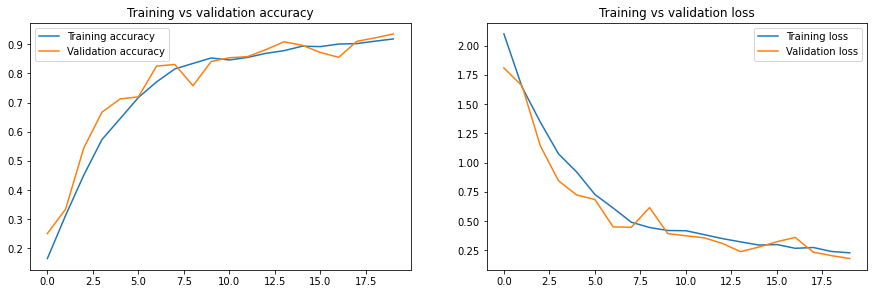

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [25]:
test_accuracy = model.evaluate(test)[1]

85/85 [==============================] - 666s 8s/step - loss: 0.2040 - accuracy: 0.9256
